# Classifying Fashion Using CNN: A Beginner's Tutorial

### References

* Excellent notebook by Pavan: https://www.kaggle.com/pavansanagapati/a-simple-cnn-model-beginner-guide

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv


## Data

In [2]:
train = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

In [3]:
train.dtypes, test.dtypes

(label       int64
 pixel1      int64
 pixel2      int64
 pixel3      int64
 pixel4      int64
             ...  
 pixel780    int64
 pixel781    int64
 pixel782    int64
 pixel783    int64
 pixel784    int64
 Length: 785, dtype: object,
 label       int64
 pixel1      int64
 pixel2      int64
 pixel3      int64
 pixel4      int64
             ...  
 pixel780    int64
 pixel781    int64
 pixel782    int64
 pixel783    int64
 pixel784    int64
 Length: 785, dtype: object)

Keras and Tensorflow use numpy 32 arrays and so we must convert

In [4]:
#splitting data into labels
y_train = train['label']
y_test = test['label']
X_train = train.drop(labels = ['label'], axis=1)
X_test = test.drop(labels = ['label'], axis = 1)

In [5]:
X_train = np.array(X_train, dtype = 'float32')
X_test = np.array(X_test, dtype = 'float32')
y_train = np.array(y_train, dtype = 'float32')
y_test = np.array(y_test, dtype = 'float32')

## Examining the DataSet

In [6]:
train.values.min(), train.values.max()

(0, 255)

We can see above that the pixel range is between 0 & 255. We need to rescale our data to a 0-1 scale for our model to perform accurately. We can do this by dividing each value by 255.

In [7]:
X_train, X_test = X_train / 255, X_test / 255

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

We need to create class names as detailed in the data reference.

Text(0.5, 1.0, 'Sandal')

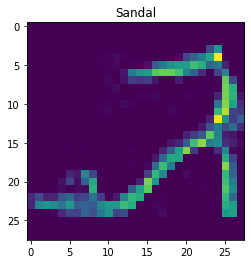

In [9]:
import matplotlib.pyplot as plt
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.imshow(X_train[0].reshape(28,28))
label = int(y_train[0])
plt.title(class_names[label])

Before we feed the data to our model we need to shape the data so that the CNN can accurately depict each image.

In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_train.shape

(48000, 28, 28, 1)

Our code now has 48,000 rows with 28 * 28 pixels each forming an image.

### Setting up a Model
* We will use a Sequential model to classify the images.
* A sequential model will take in a flatten layer which will convert our two dimensional array to a one dimensional array. (28 X 28 = 784; if you look at the shape of the data you can see that it is 28 X 28 if we want to create an image, shown above).
* We will also instantiate Dense layers which are fully connected nueral layers. These layers have a lot of parameters along with weights and biases. If you call model.layers[1] you will get the first layer and can then call model.layers[1].weights to get the associated weights for that layer.
* The last Dense layer will be however many classes there are. For this model we will be using 10 different classes. This layer returns an array of proabilities associated with how likely that the current image belongs to each class. Remember, 10 different classes, therefore 10 values in the array with sum(probabilities) = 1. The highest probability in the array will be the class assigned to the image. 

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, MaxPooling2D, Dropout, Dense, Conv2D

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [28,28, 1]))

model.add(MaxPooling2D(pool_size = (2)))
model.add(Dropout(0.25)) # reduces overfitting
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                173088    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
__________________________________________________

## Compiling 
* Loss: We will use sparse_categorical_crossentropy as we have are solving a multiclass machine learning problem (10 classes). If we were doing one-hot we would use categorical crossentropy but that is not appropriate for this model. 
* Optimizer: Adam is widely used and a good start for beginners. (Descriptionon adam here later)
* Metrics: in this model we will be using accuracy. This measures how many images are correcntly classified. One of the more simplistic metrics and good for beginners as generally we want to know how many images we classified correctly

In [12]:
from keras.optimizers import Adam
model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

### Early Stopping

I am going to use early stopping to save training time in case we don't improve our model accuracy.

In [13]:
#if we want to implement early stopping to save training time we can modify below as model.fit(X_train, y_train, batch_size = 128, epochs = 50, verbose = 1,
#validation_data = (X_valid, y_valid), callbacks = stop)

from keras.callbacks import EarlyStopping
stop = EarlyStopping(patience = 15) # patience stands for 15 epochs 

In [14]:
history = model.fit(X_train, y_train, batch_size = 400, epochs = 75, verbose = 1, validation_data = (X_valid, y_valid))

Epoch 1/75
120/120 [==============================] - 13s 107ms/step - loss: 0.7431 - accuracy: 0.7476 - val_loss: 0.4991 - val_accuracy: 0.8138
Epoch 2/75
120/120 [==============================] - 12s 98ms/step - loss: 0.4477 - accuracy: 0.8434 - val_loss: 0.4243 - val_accuracy: 0.8506
Epoch 3/75
120/120 [==============================] - 12s 103ms/step - loss: 0.3996 - accuracy: 0.8604 - val_loss: 0.3793 - val_accuracy: 0.8700
Epoch 4/75
120/120 [==============================] - 12s 101ms/step - loss: 0.3755 - accuracy: 0.8703 - val_loss: 0.3690 - val_accuracy: 0.8689
Epoch 5/75
120/120 [==============================] - 12s 101ms/step - loss: 0.3508 - accuracy: 0.8774 - val_loss: 0.3494 - val_accuracy: 0.8784
Epoch 6/75
120/120 [==============================] - 13s 106ms/step - loss: 0.3321 - accuracy: 0.8835 - val_loss: 0.3319 - val_accuracy: 0.8860
Epoch 7/75
120/120 [==============================] - 12s 98ms/step - loss: 0.3222 - accuracy: 0.8866 - val_loss: 0.3187 - val_accu

It seems that our model is very accurate but we do have moderate loss (~around .3).

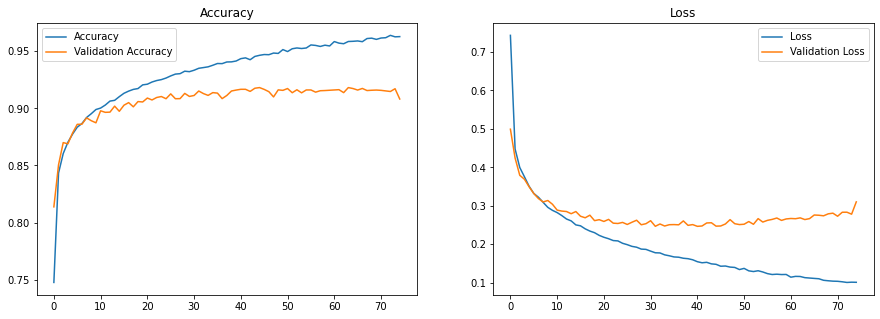

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].plot(history.history['accuracy'], label = 'Accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label = 'Loss')
ax[1].plot(history.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()

## Predictions

In [16]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Accuracy: ' + str(score[1]))
print('Loss: ' + str(score[0]))

313/313 [==============================] - 1s 5ms/step - loss: 0.2909 - accuracy: 0.9146
Accuracy: 0.9146000146865845
Loss: 0.2908690273761749


In [17]:
predicted_classes = model.predict_classes(X_test)
predicted_classes = predicted_classes.reshape(-1,1)
y_true = test['label']

pred_df = pd.DataFrame(predicted_classes)

In [18]:
pred_df['Actual'] = y_true

In [19]:
cols = ['Predictions', 'Actual']
pred_df.columns = [i for i in cols]
pred_df

,Predictions,Actual
0,0,0
1,1,1
2,2,2
3,2,2
4,3,3
...,...,...
9995,0,0
9996,6,6
9997,8,8
9998,8,8


In [20]:
from sklearn.metrics import classification_report

In [21]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

print(classification_report(y_true, predicted_classes, target_names = classes))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.91      0.86      1000
           3       0.90      0.94      0.92      1000
           4       0.93      0.81      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.82      0.70      0.76      1000
           7       0.97      0.95      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

